In [85]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd
import xarray as xr
from sklearn.preprocessing import scale
import scipy
from scipy.special import expit
import pytensor.tensor as pt
import graphviz
from sklearn.linear_model import LinearRegression
import rdata
import sunode
import sunode.wrappers.as_pytensor

## Generalized Linear Habits

GLMs and GLMMs: Flexible association description machines

With external causal model, causal interpretation possible

But only a fraction of scientific phenomenca expressible as GLM(M)s

Even when GLM(M)s sufficient, starting with theory solves empirical problems

## Cartoon Human Volume

- Start with the approximation that humans are cylinders

- Most volume for a human comes from your height and your radius.

- $V = \pi r^2h$ V = volume, r = radius, h = height

- $V = \pi (ph)^2h$ radius as prportion of height

- $W = kV = k \pi (ph)^2h$ W = weight, k="density"

- $W = k \pi p^2 h^3$

- We have weight and height data

## Statistical model

$W_i \sim Distribution(\mu_i,...)$ 'error' distribution for W

$\mu_i = k \pi p^2 H^{3}_{i}$ Expected W for H 

$p \sim Distribution(...)$ prior for proportionality

$k \sim Distribution(...)$ prior for density

How to set priors?

1) Choose measurement scales
2) Simulate
3) Think

Units in the equation:

$\mu_i(kg) = k(kg/cm^3)H^{3}_{i}(cm^3)$

**Measurement scales are artifice**

If you can divide out all measurement scales (kg,cm), often easier

divide weight by mean weight and height by mean height

$p \sim Distribution(...)$ between 0-1, <0.5

$k \sim Distribution(...)$ positive real, >1

$p \sim Beta(25,50)$

$k \sim Exponential(0.5)$

In [2]:
np.pi

3.141592653589793

C:\Users\Kieran McGee\AppData\Local\Temp\ipykernel_17592\587324195.py:8: RuntimeWarning: divide by zero encountered in log
  mu = np.log(np.pi *k[i]*p[i]**2*xseq**3)


Text(0, 0.5, 'Weight (scaled)')

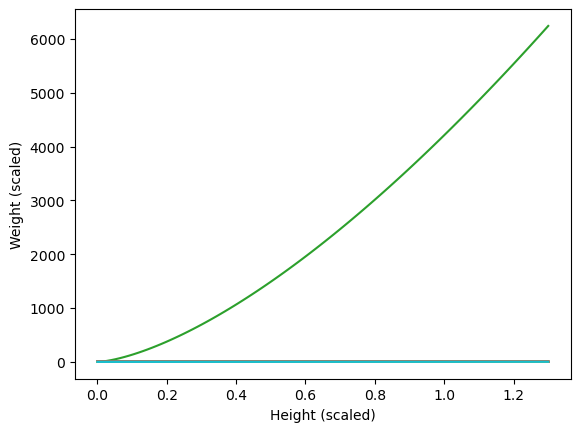

In [3]:
n = 30
p = np.random.beta(25,50,size=n)
k = np.random.exponential(0.5,size=n)
sigma = np.random.exponential(1,size=n)

xseq = np.linspace(0,1.3,num=100)
for i in range(n):
    mu = np.log(np.pi *k[i]*p[i]**2*xseq**3)
    plt.plot(xseq,np.exp((mu+sigma[i]**2)/2))
plt.xlabel('Height (scaled)')
plt.ylabel('Weight (scaled)')

$W_i \sim LogNormal(\mu_i,sigma)$ Growth is multiplication, log-normal is natural choice

$exp(\mu_i) = k \pi p^3 H^{3}_{i}$ mu in log-normal is mean of log, not mean of observed

$p \sim Beta(25,50)$

$k \sim Exponential(0.5)$

In [4]:
howell = pd.read_csv('Data/Howell1.csv',sep=';')
howell.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [5]:
with pm.Model() as m161:
    H = pm.MutableData('H',howell['height'].values/howell['height'].mean())
    Wobs = pm.MutableData('Wobs',howell['weight'].values/howell['weight'].mean())

    
    k = pm.Exponential('k',0.5)
    p = pm.Beta('p',25,50)
    sigma = pm.Exponential('sigma',1)
    mu = np.log(np.pi*k *(p**2) * (H**3))
    W = pm.LogNormal('W',mu,sigma,observed=Wobs)
    m161_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, p, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


In [6]:
with m161:
    pm.sample_posterior_predictive(m161_trace,extend_inferencedata=True)

Sampling: [W]


In [7]:
m161_trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

In [8]:
az.hdi(m161_trace.posterior_predictive.W)

<xarray.Dataset>
Dimensions:  (W_dim_2: 544, hdi: 2)
Coordinates:
  * W_dim_2  (W_dim_2) int32 0 1 2 3 4 5 6 7 ... 536 537 538 539 540 541 542 543
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    W        (W_dim_2, hdi) float64 0.7784 1.765 0.6397 ... 0.1831 0.9335 2.048

Text(0, 0.5, 'weight (scaled)')

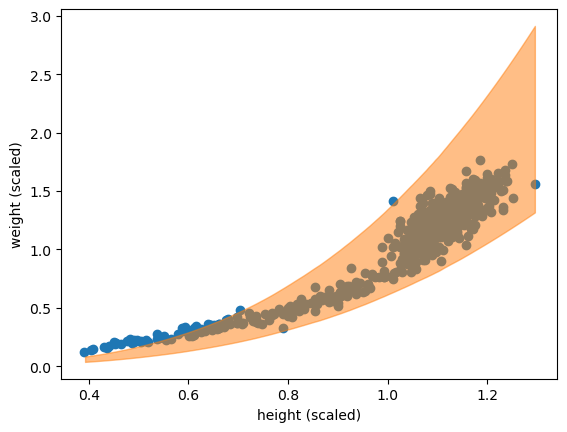

In [9]:
H = howell['height'].values/howell['height'].mean()
plt.scatter(x=H,y=howell['weight'].values/howell['weight'].mean())
az.plot_hdi(x=H,y=m161_trace.posterior_predictive.W)
plt.xlabel('height (scaled)')
plt.ylabel('weight (scaled)')

## Insightful errors

Not bad for a cylinder

Poor fit for children

In scientific model, poor fit is informative - p different for kids

Bad epicycles harder to read 

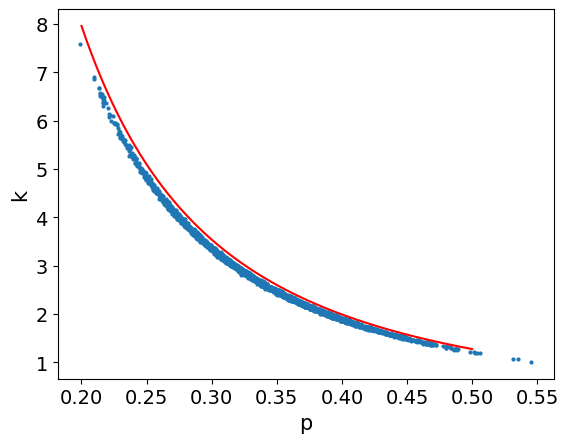

In [10]:
az.plot_pair(m161_trace,var_names =['p','k'])
p = np.linspace(0.2,0.5,400)
k = 1/(np.pi*p**2)
plt.plot(p,k,c='r')

Observe the curve that expresses the relationship between k and p. These parameters are completely unnecessary!

$\mu_i = k \pi p^2 H^{3}_{i}$

$(1) = k \pi p^2 (1)^3$ inserting mean value

$k = 1/{\pi p^2}$

$(1) = \pi \theta (1)^3$

$ \theta \approx \pi^-1$

In dimensionless model, W is H^3
There are no free parameters in this model!

In [11]:
with pm.Model() as MWH2:
    H = pm.MutableData('H',howell['height'].values/howell['height'].mean())
    Wobs = pm.MutableData('Wobs',howell['weight'].values/howell['weight'].mean())

    sigma = pm.Exponential('sigma', 1)
    mu = np.log(H**3)
    W = pm.LogNormal('W',mu,sigma,observed=Wobs)
    MWH2_trace = pm.sample()
    pm.sample_posterior_predictive(MWH2_trace,extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Sampling: [W]


Text(0, 0.5, 'weight (scaled)')

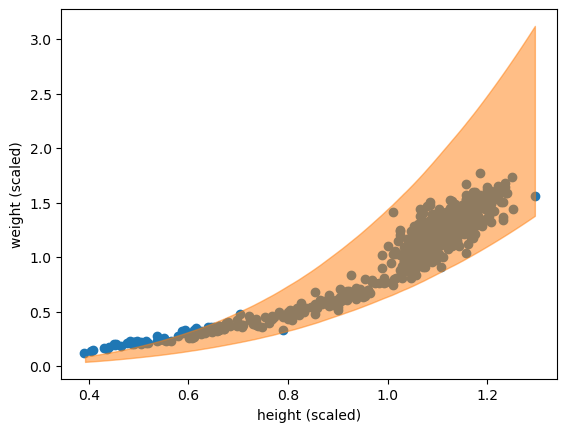

In [12]:
H = howell['height'].values/howell['height'].mean()
plt.scatter(x=H,y=howell['weight'].values/howell['weight'].mean())
az.plot_hdi(x=H,y=MWH2_trace.posterior_predictive.W)
plt.xlabel('height (scaled)')
plt.ylabel('weight (scaled)')

## Geometric People

Most of the relationship H -> W is just relationship between length and volume

Changes in body shape explain poor fit for childrend?

Problems provide insight when model is scientific instead of purely statistical 

There is no empiricism without theory

## Social Conformity ##

Do children copy the majority? If so, how does this develop?

Problem: Cannot see strategy, only choice

Majority choice consistent with many strategies

Random color: Choose majority 1/3 of time

Random demonstrator: 3/4 of time

Random demonstration: 1/2 of time

In [13]:
#Simulation

n = 100 #Number of children

#Half choose random color
#Sample from 1,2,3 at random for each
y1 = np.random.choice(a=[0,1,2],size=int(n/2),replace=True)

#Half follow majority
y2 = (np.ones(50) *2).astype(int)

y = np.concatenate((y1,y2))
#y = np.random.shuffle(y)

## State-Based Model

Majority choice does not indicate majority preference 

Instead infer the unobserved strategy (state) of each child

Strategy space:
1) Majority
2) Minority
3) Maverick
4) Random Color
5) Follow first

Building the stat model

$Y_i \sim Categorical(\theta)$ Probability of 1) Unchosen, 2) majority, 3) minority

$\theta_j = \sum_{S=1}^5 p_S Pr(Y=j|S)$

$\theta_j  $Probability of choice j

$\sum_{S=1}^5$ average over strategies 

$p_S$ Prior probability of strategy S

$Pr(Y = j|S)$ Probability of choice j assuming strategy S. We know and can just write this one in 

$p \sim Dirichlet([4,4,4,4,4])$ prior for strategy space

In [14]:
np.zeros(5)

array([0., 0., 0., 0., 0.])

In [15]:
1 == 1.0

True

In [16]:
boxes = pd.read_csv('Data/Boxes.csv',sep=';')
len(boxes)

629

In [67]:
#Partially adapted from Rethinking 2 notes, updated for pytensor and CustomDist() API

#Defining a custom logp for our model. 
def child_logp(y,p,majority_first): # Order of arguments is important, value (y in our case) must be first. 
    
    theta_j = [None] * 5

    # Probability of data
    theta_j[0] = pt.switch(pt.eq(y, 2), 1, 0)
    theta_j[1] = pt.switch(pt.eq(y, 3), 1, 0)
    theta_j[2] = pt.switch(pt.eq(y, 1), 1, 0)
    theta_j[3] = pt.ones_like(y) * 1 / 3
    theta_j[4] = pt.switch(
        pt.eq(majority_first, 1), pt.switch(pt.eq(y, 2), 1, 0), pt.switch(pt.eq(y, 3), 1, 0)
    )

    # Compute log ( p_s * Pr(y_i|s) )
    for i in range(5):
        theta_j[i] = pt.log(theta_j[i]) + pt.log(p[i])

    # Compute average log-probability of y_i
    return  pt.sum(pm.math.logsumexp(theta_j, axis=0))

coords = {'strategy':['majority','minority','maverick','color','first']}

with pm.Model(coords=coords) as child_m:
    
    #Data 
    y = pm.MutableData('y',boxes['y'].values)
    majority_first = pm.MutableData('majority_first',
                                    boxes['majority_first'].values)
    
    #Prior
    
    p = pm.Dirichlet('p',np.array([4,4,4,4,4]),dims='strategy')
    
    #Probability of data, whats the probability that a strategy 
    #produces a result
    
    likelihood = pm.CustomDist('likelihood',p,majority_first,logp=child_logp,observed=y) #Note argument order! 
        
    child_trace = pm.sample()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [68]:
az.summary(child_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[majority],0.257,0.037,0.189,0.329,0.001,0.001,1228.0,1693.0,1.0
p[minority],0.138,0.034,0.072,0.201,0.001,0.001,1190.0,1320.0,1.0
p[maverick],0.149,0.030,0.093,0.205,0.001,0.001,1143.0,1420.0,1.0
p[color],0.196,0.083,0.058,0.356,0.003,0.002,921.0,974.0,1.0
p[first],0.260,0.033,0.200,0.321,0.001,0.000,3845.0,3302.0,1.0


array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

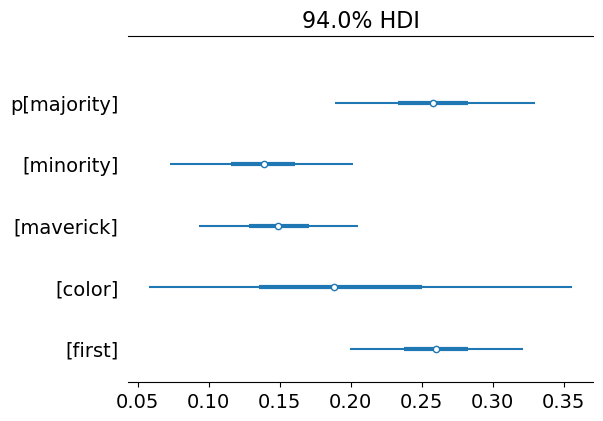

In [69]:
az.plot_forest(child_trace,combined=True)

## State-Based Models

What we wants: Latent states

What we have : Emissions

Typically lots of uncertainty, but being honest is the only ethical choice

Large family: Movement, learning, population dynamics, international relations, family planning 

## Population Dynamics

Latent states can be time varying 

Example: Ecological dynamics, numbers of different species over time

Estimand: How do different species interact; how do interactions influence population dynamics. 

## Lotka-Volterra example

In [79]:
lh = pd.read_csv('Data/Lynx_Hare.csv',sep=';')
lh.head()

,Year,Lynx,Hare
0,1900,4.0,30.0
1,1901,6.1,47.2
2,1902,9.8,70.2
3,1903,35.2,77.4
4,1904,59.4,36.3


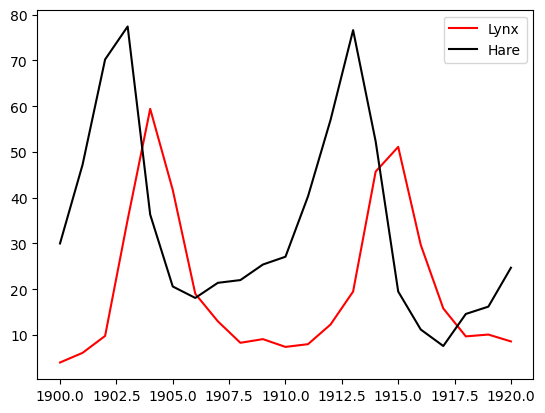

In [82]:
plt.plot(lh.Year, lh['Lynx'],label='Lynx',c='red')
plt.plot(lh.Year, lh['Hare'],label='Hare',c='black')
plt.legend()

$dH/dt = H_t(birth rate) - H_t(deathrate)$ Hare population change over time

$dH/dt = L_t(birthrate) - L_t(deathrate)$ Lynx population change over time

${dH}/{dt} =H_tb_H - H_t(L_tm_H)$ hare birth rate, mH = impact of lynx on hares

$dL/dt = L_t(H_tb_L) -L_tm_L$ birth rate of lynx depends on population of hares

Two vectors of observed variables to explain, each at time t

Positive numbers of pelts with error on them. 

$h_t \sim LogNormal(log(p_HH_t),\sigma_H)$

$H_T = H_1 + \int_{1}^TdH/dt dt$ Cumulative changes in H until time T

$l_t \sim LogNormal(log(p_lL_t),\sigma_L)$

$L_T = L_1 + \int_{1}^TdL/dt dt$ Cumulative changes in L until time T



In [89]:

times = lh['Year']
lynx_data = lh['Lynx'].values
hare_data = lh['Hare'].values

In [101]:
lh.Year.values.astype(float)

array([1900., 1901., 1902., 1903., 1904., 1905., 1906., 1907., 1908.,
       1909., 1910., 1911., 1912., 1913., 1914., 1915., 1916., 1917.,
       1918., 1919., 1920.])

In [ ]:
#Adapted from sunode documentation 
#Defining the right hand side equation 
def lotka_volterra(t, y, p):
    """Right hand side of Lotka-Volterra equation.

    All inputs are dataclasses of sympy variables, or in the case
    of non-scalar variables numpy arrays of sympy variables.
    """
    return {
        'hares': (p.bh - p.mh * y.lynx) * y.hares,
        'lynx':  (p.bl * y.hares - p.ml) * y.lynx,
    }

with pm.Model() as lh_m:
    #hare_init = lh['Hare'][0]
    #lynx_init = lh['Lynx'][0]
    #Data
    N = len(lh)
    lp = pm.MutableData('lp',lh['Lynx'].values)
    hp = pm.MutableData('hp',lh['Hare'].values)
    times = pm.MutableData('times',lh['Year'].values.astype(float))
    
    
    #priors
    bh = pm.Normal('bh',1,0.5)
    ml = pm.Normal('ml',1,0.5)
    mh = pm.Normal('mh',0.05,0.05)
    bl = pm.Normal('bl',0.05,0.05)
    sigma = pm.Exponential('sigma',1)
    #pop_init = pm.LogNormal('pop_init',np.log(10),1)
    hare_init = pm.LogNormal('hare_init',np.log(10),1)
    lynx_init = pm.LogNormal('lynx_init',np.log(10),1)
    p = pm.Beta('p',40,200)
    
    
    y0 = {
        # The initial number of hares is the random variable `hares_start`,
        # and it has shape (), so it is a scalar value.
        'hares': (hare_init, ()),
        'lynx': (lynx_init, ()),
    }

    params = {
        'bh': (bh, ()),
        'ml': (ml, ()),
        'mh': (mh, ()),
        'bl': (bl, ()),
        # Parameters (or initial states) do not have to be random variables,
        # they can also be fixed numpy values. In this case the shape
        # is infered automatically. Sunode will not compute derivatives
        # with respect to fixed parameters or initial states.
        'unused_extra': np.zeros(5),
    }
    
    from sunode.wrappers.as_pytensor import solve_ivp
    solution, *_ = solve_ivp(
        y0=y0,
        params=params,
        rhs=lotka_volterra,
        # The time points where we want to access the solution
        tvals=times,
        t0=times[0],
    )
    
    #Do a bit more, need to log the solution and multiply and such 
    hares = pm.LogNormal('hares',mu=solution['hares'],sigma=sigma,observed=hp)
    lynx  = pm.LogNormal('lynx',mu=solution['lynx'],sigma=sigma,observed=lp)
    
    #Sunode can't pickle the ODE solver, use the following if working on mac, see sunode docs: 
    #import multiprocessing as mp
        #mp.set_start_method('fork')
    
    lh_trace = pm.sample(chains = 4,cores=1) # sunode can't pickle the ODE solver, need to specify 1 core on Windows.  